In [85]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

Noise shape: (1, 100)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_6 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_41 (Conv2D  (None, 14, 14, 128)      819200    
 Transpose)                                                      
                                                                 
 batch_normalization_7 (Batc  (

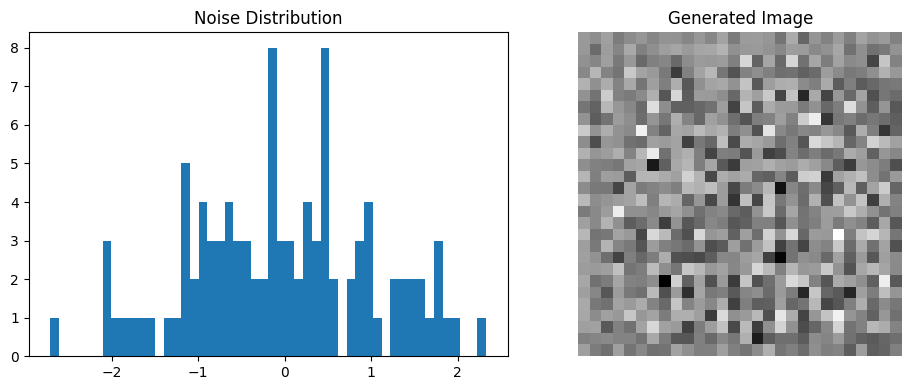

In [86]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

def build_generator():
    # Properly structure the generator to transform from noise to image
    return tf.keras.Sequential([
        # Start with a Dense layer to process the 1D noise vector
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        # Reshape to a small convolutional feature map
        layers.Reshape((7, 7, 256)),
        
        # Upsample to 14x14
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        # Upsample to 28x28
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        # Output layer with tanh activation
        layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])

# Create a batch of noise vectors
batch_size = 1
noise_dim = 100
noise = tf.random.normal([batch_size, noise_dim])
print("Noise shape:", noise.shape)

# Don't try to plot the noise vector as an image
# Instead, we can visualize its distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(noise.numpy().flatten(), bins=50)
plt.title('Noise Distribution')

# Build and use the generator
generator = build_generator()
generator.summary()  # Print the model architecture

# Generate an image
generated_image = generator(noise, training=False)
print("Generated image shape:", generated_image.shape)

# Rescale from [-1,1] to [0,1] for visualization
generated_image = (generated_image + 1) / 2.0

# Plot the generated image
plt.subplot(1, 2, 2)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.title('Generated Image')
plt.axis('off')
plt.tight_layout()
plt.show()

In [87]:
def descriminator_builder():
    return tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(128, (2, 2), padding='same'),
        layers.Conv2D(64, (2, 2), padding='same'),
        layers.Conv2D(128, (2, 2), padding='same'),
        layers.Conv2D(1, (2, 2), padding='same'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])


In [88]:
descriminator = descriminator_builder()
descriminator(generated_image)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49783078]], dtype=float32)>

In [89]:
loss = tf.keras.losses.BinaryCrossentropy()
def discriminator_los(image, generated_image):
    return loss(tf.ones_like(image), image) + loss(tf.zeros_like(generated_image), generated_image)
def generator_los(image):
    return loss(tf.ones_like(image), image) 

gen_optim = tf.keras.optimizers.Adam(1e-4)
des_optim = tf.keras.optimizers.Adam(1e-4)


In [102]:
@tf.function()
def train_step(image):
    batch_size = tf.shape(image)[0]
    noise = tf.random.normal([batch_size, 100])
    with tf.GradientTape() as genG, tf.GradientTape() as disG:
        gen = generator(noise)
        des_r = descriminator(image)
        des_f = descriminator(gen)
        des_loss = discriminator_los(des_r, des_f)
        gen_loss = generator_los(des_f)
    
    gradient_gen = genG.gradient(gen_loss, generator.trainable_variables)
    gradient_dis = disG.gradient(des_loss, descriminator.trainable_variables)
    gen_optim.apply_gradients(zip(gradient_gen, generator.trainable_variables))
    des_optim.apply_gradients(zip(gradient_dis, descriminator.trainable_variables))


In [103]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(64)


In [104]:
iter(train_dataset).next().shape

TensorShape([64, 28, 28])

In [105]:
def train():
    for i in range(10):
        for batch in train_dataset:
            train_step(batch)
        print("epoch = {i}")
train()

epoch = {i}
epoch = {i}
epoch = {i}
epoch = {i}
epoch = {i}
epoch = {i}
epoch = {i}
epoch = {i}
epoch = {i}
epoch = {i}


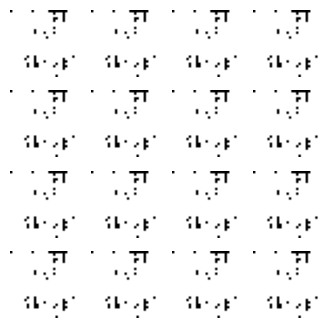

In [106]:
def generate_and_save_images(model):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

test_input = tf.random.normal([16, 100])
generate_and_save_images(generator)